In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import backtrader as bt
import MetaTrader5 as mt5
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import shared

MetaTrader 5 initialized successfully.


In [2]:
PAIRS = ["WTI", "BRN", "USDJPY", "EURUSD", "GBPUSD", "EURGBP", "XAUUSD", 'CADCHF', 'XAGUSD', 'AUDUSD', 'USDCNH', 'EURCHF', 'NZDUSD']
TIMEFRAME = mt5.TIMEFRAME_D1
BARS = 300
WINDOW_FACTOR = 14

In [3]:
shared.fill_data(PAIRS, TIMEFRAME, BARS)

Fetched data for pair: WTI
Fetched data for pair: BRN
Fetched data for pair: USDJPY
Fetched data for pair: EURUSD
Fetched data for pair: GBPUSD
Fetched data for pair: EURGBP
Fetched data for pair: XAUUSD
Fetched data for pair: CADCHF
Fetched data for pair: XAGUSD
Fetched data for pair: AUDUSD
Fetched data for pair: USDCNH
Fetched data for pair: EURCHF
Fetched data for pair: NZDUSD


In [4]:
for symbol, data in shared.data.items():
    shared.data[symbol]['rsi'] = ta.rsi(data['close'], length=WINDOW_FACTOR)
    shared.data[symbol] = shared.data[symbol].dropna(subset=['rsi'])

In [5]:
# Configuration Variables
RSI_LOWER = 20
RSI_UPPER =80
INITIAL_CAPITAL = 10000
LEVERAGE = 10  # Leverage factor (e.g., 10x)
TP_SL_RATIO = 4  # Ratio between TP and SL (e.g., 2:1)
SPREAD_PERCENT = 0.012  # Overall spread between entry and TP/SL (e.g., 3%)
TRANSACTION_COST = 0.001  # Transaction cost as a percentage of the trade value (e.g., 0.1%)
CAPITAL_ALLOCATION_PER_TRADE = 0.1  # Allocate 10% of capital per trade

# Initialize an empty list to store trade details
trades = []

# Iterate through each symbol's data
for symbol, data in shared.data.items():
    capital = INITIAL_CAPITAL
    open_positions = []

    for index, row in data.iterrows():
        rsi = row['rsi']
        close_price = row['close']
        trade_time = row['time']

        # Check for entry signals
        if rsi < RSI_LOWER or rsi > RSI_UPPER:
            if (rsi < RSI_LOWER and not any(pos['position'] == 'long' for pos in open_positions)) or \
               (rsi > RSI_UPPER and not any(pos['position'] == 'short' for pos in open_positions)):

                position_type = 'long' if rsi < RSI_LOWER else 'short'
                entry_price = close_price
                allocated_capital = capital * CAPITAL_ALLOCATION_PER_TRADE
                spread = entry_price * SPREAD_PERCENT
                tp = entry_price + spread if position_type == 'long' else entry_price - spread
                sl = entry_price - (spread / TP_SL_RATIO) if position_type == 'long' else entry_price + (spread / TP_SL_RATIO)
                
                # Calculate transaction cost when opening a position
                transaction_cost = TRANSACTION_COST * LEVERAGE * allocated_capital
                allocated_capital -= transaction_cost
                capital -= allocated_capital
                
                open_positions.append({
                    'symbol': symbol,
                    'entry_time': trade_time,
                    'entry_price': entry_price,
                    'sl': sl,
                    'tp': tp,
                    'position': position_type,
                    'allocated_capital': allocated_capital,
                    'transaction_cost': transaction_cost
                })

        # Check for exit signals
        for position in open_positions.copy():
            if position['position'] == 'long' and (rsi > RSI_UPPER or close_price >= position['tp'] or close_price <= position['sl']):
                profit = (close_price - position['entry_price']) * LEVERAGE * position['allocated_capital'] / position['entry_price']
                capital += profit - position['transaction_cost']
                max_drawdown = (position['entry_price'] - min(data.loc[index:, 'close'])) * LEVERAGE * position['allocated_capital'] / position['entry_price']
                
                trades.append({
                    'symbol': position['symbol'],
                    'entry_time': position['entry_time'],
                    'exit_time': trade_time,
                    'entry_price': position['entry_price'],
                    'close_price': close_price,
                    'pnl': profit - position['transaction_cost'],
                    'max_drawdown': max_drawdown,
                    'tp': position['tp'],
                    'sl': position['sl'],
                    'position': position['position']
                })
                open_positions.remove(position)
            
            elif position['position'] == 'short' and (rsi < RSI_LOWER or close_price <= position['tp'] or close_price >= position['sl']):
                profit = (position['entry_price'] - close_price) * LEVERAGE * position['allocated_capital'] / position['entry_price']
                capital += profit - position['transaction_cost']
                max_drawdown = (max(data.loc[index:, 'close']) - position['entry_price']) * LEVERAGE * position['allocated_capital'] / position['entry_price']
                
                trades.append({
                    'symbol': position['symbol'],
                    'entry_time': position['entry_time'],
                    'exit_time': trade_time,
                    'entry_price': position['entry_price'],
                    'close_price': close_price,
                    'pnl': profit - position['transaction_cost'],
                    'max_drawdown': max_drawdown,
                    'tp': position['tp'],
                    'sl': position['sl'],
                    'position': position['position']
                })
                open_positions.remove(position)

    # Ensure that any open positions are closed at the final market price
    final_row = data.iloc[-1]
    final_price = final_row['close']
    final_time = final_row['time']

    for position in open_positions:
        if position['position'] == 'long':
            profit = (final_price - position['entry_price']) * LEVERAGE * position['allocated_capital'] / position['entry_price']
        elif position['position'] == 'short':
            profit = (position['entry_price'] - final_price) * LEVERAGE * position['allocated_capital'] / position['entry_price']

        # Calculate transaction cost when closing a position
        transaction_cost = TRANSACTION_COST * LEVERAGE * position['allocated_capital']
        capital += profit - transaction_cost

        max_drawdown = (position['entry_price'] - min(data['close'])) * LEVERAGE * position['allocated_capital'] / position['entry_price'] if position['position'] == 'long' else (max(data['close']) - position['entry_price']) * LEVERAGE * position['allocated_capital'] / position['entry_price']
        
        trades.append({
            'symbol': position['symbol'],
            'entry_time': position['entry_time'],
            'exit_time': final_time,
            'entry_price': position['entry_price'],
            'close_price': final_price,
            'pnl': profit - transaction_cost,
            'max_drawdown': max_drawdown,
            'tp': position['tp'],
            'sl': position['sl'],
            'position': position['position']
        })

# Convert trades to a DataFrame for analysis
trades_df = pd.DataFrame(trades)
trades_df['capital'] = INITIAL_CAPITAL + trades_df['pnl'].cumsum()

trades_df

,symbol,entry_time,exit_time,entry_price,close_price,pnl,max_drawdown,tp,sl,position,capital
0,USDJPY,2024-04-25,2024-04-26,155.64000,158.28900,-178.498458,385.848111,153.772320,156.106920,short,9821.501542
1,USDJPY,2024-08-01,2024-08-02,149.36200,146.57500,-171.973806,412.099685,151.154344,148.913914,long,9649.527736
2,USDJPY,2024-08-05,2024-08-07,144.18100,146.76500,130.345408,99.374929,145.911172,143.748457,long,9779.873144
3,EURUSD,2023-08-02,2023-08-15,1.09379,1.09026,-41.950374,426.668739,1.106915,1.090509,long,9737.922770
4,GBPUSD,2023-09-26,2023-10-02,1.21541,1.20871,-64.574177,62.556668,1.229995,1.211764,long,9673.348593
5,XAUUSD,2023-10-02,2023-10-04,1828.01000,1820.77000,-49.209851,42.567601,1849.946120,1822.525970,long,9624.138742
6,XAUUSD,2023-10-05,2023-10-09,1820.15000,1861.31000,191.647875,-194.321367,1841.991800,1814.689550,long,9815.786617
7,XAUUSD,2024-03-06,2024-03-07,2148.37000,2159.46000,-50.504679,1431.643861,2122.589560,2154.815110,short,9765.281937
8,XAUUSD,2024-03-08,2024-03-20,2178.54000,2185.54000,-30.925187,1162.012247,2152.397520,2185.075620,short,9734.356750
9,XAUUSD,2024-04-02,2024-04-03,2280.02000,2300.01000,-64.209595,703.443856,2252.659760,2286.860060,short,9670.147155


In [6]:
# Calculate Performance Metrics
total_profit = trades_df['pnl'].sum()
num_trades = len(trades_df)
win_rate = (trades_df['pnl'] > 0).mean()
max_drawdown = trades_df['max_drawdown'].max()
avg_drawdown = trades_df['max_drawdown'].mean()
best_trade = trades_df['pnl'].max()
worst_trade = trades_df['pnl'].min()
avg_trade = trades_df['pnl'].mean()
trade_durations = (trades_df['exit_time'] - trades_df['entry_time'])
max_trade_duration = trade_durations.max()
avg_trade_duration = trade_durations.mean()
profit_factor = trades_df.loc[trades_df['pnl'] > 0, 'pnl'].sum() / -trades_df.loc[trades_df['pnl'] < 0, 'pnl'].sum()

# Capital Metrics
initial_capital = INITIAL_CAPITAL
final_capital = trades_df['capital'].iloc[-1]
max_capital = trades_df['capital'].max()
min_capital = trades_df['capital'].min()

# Annualized Volatility, Sharpe Ratio, Sortino Ratio, Calmar Ratio
trading_days = 252
annualized_volatility = trades_df['pnl'].std() * np.sqrt(trading_days)
sharpe_ratio = trades_df['pnl'].mean() / trades_df['pnl'].std() * np.sqrt(trading_days)
sortino_ratio = trades_df['pnl'].mean() / trades_df[trades_df['pnl'] < 0]['pnl'].std() * np.sqrt(trading_days)
calmar_ratio = trades_df['pnl'].sum() / max_drawdown

# Summary Table with Proper Formatting
performance_summary = pd.DataFrame({
    'Metric': ['Initial Capital', 'Final Capital', 'Maximum Capital', 'Minimum Capital', 
               'Volatility (Ann.)', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown',
               'Avg. Drawdown', '# Trades', 'Win Rate', 'Best Trade', 'Worst Trade', 'Avg. Trade',
               'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor'],
    'Value': [initial_capital, final_capital, max_capital, min_capital,
              annualized_volatility, sharpe_ratio, sortino_ratio, calmar_ratio, max_drawdown,
              avg_drawdown, num_trades, win_rate, best_trade, worst_trade, avg_trade,
              max_trade_duration, avg_trade_duration, profit_factor]
})

# Apply formatting to the 'Value' column
performance_summary['Value'] = performance_summary['Value'].apply(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)

# Display performance summary
performance_summary

,Metric,Value
0,Initial Capital,10000.00
1,Final Capital,9477.92
2,Maximum Capital,9821.50
3,Minimum Capital,9391.45
4,Volatility (Ann.),1472.97
5,Sharpe Ratio,-4.06
6,Sortino Ratio,-8.76
7,Calmar Ratio,-0.36
8,Max. Drawdown,1431.64
9,Avg. Drawdown,300.42


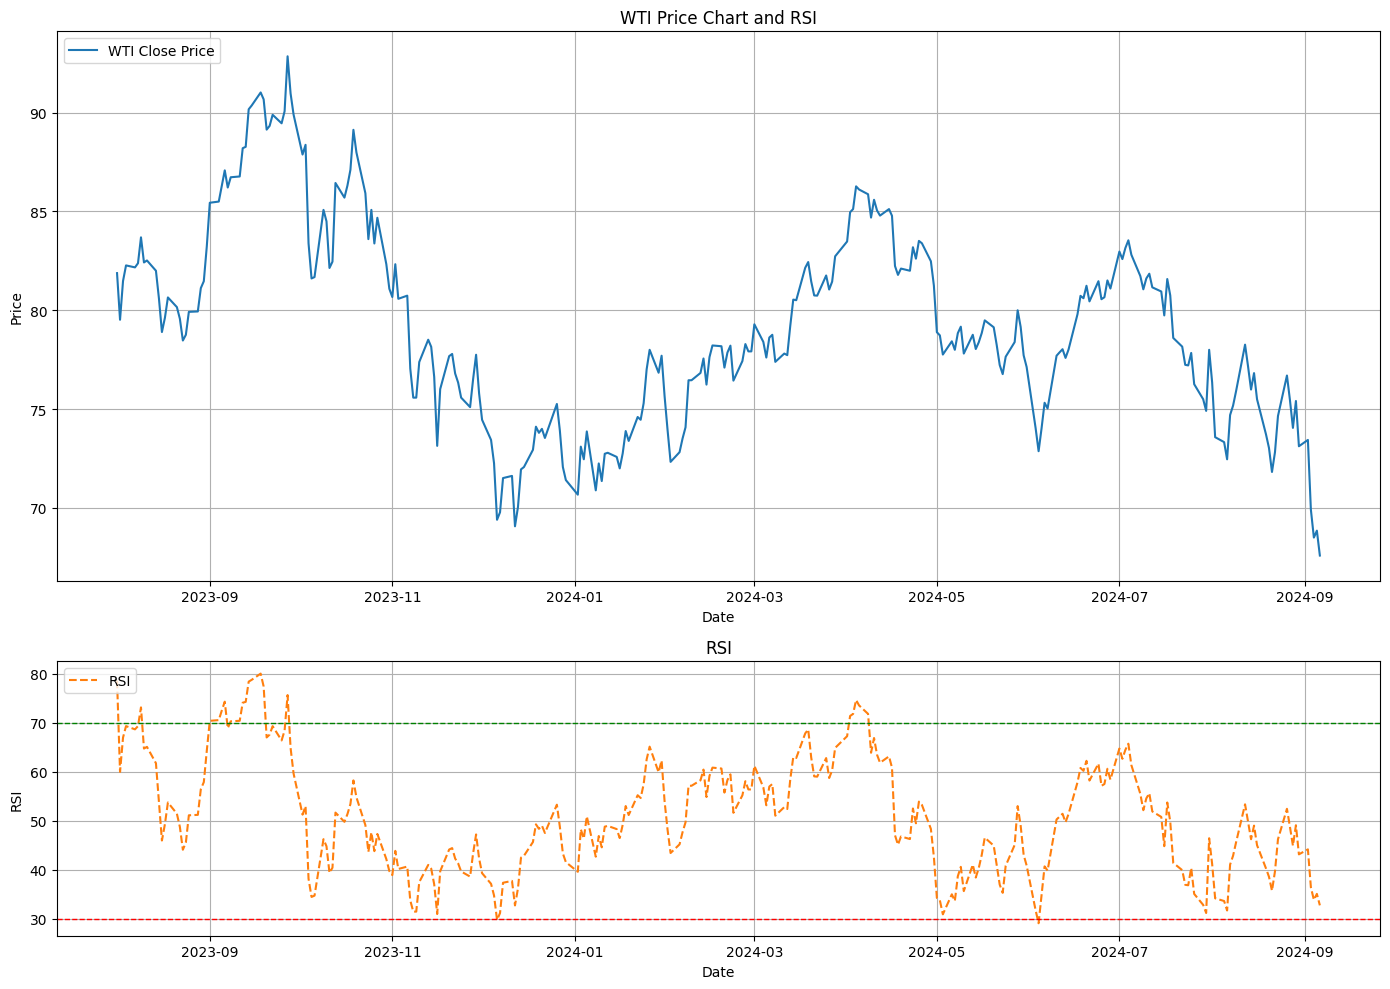

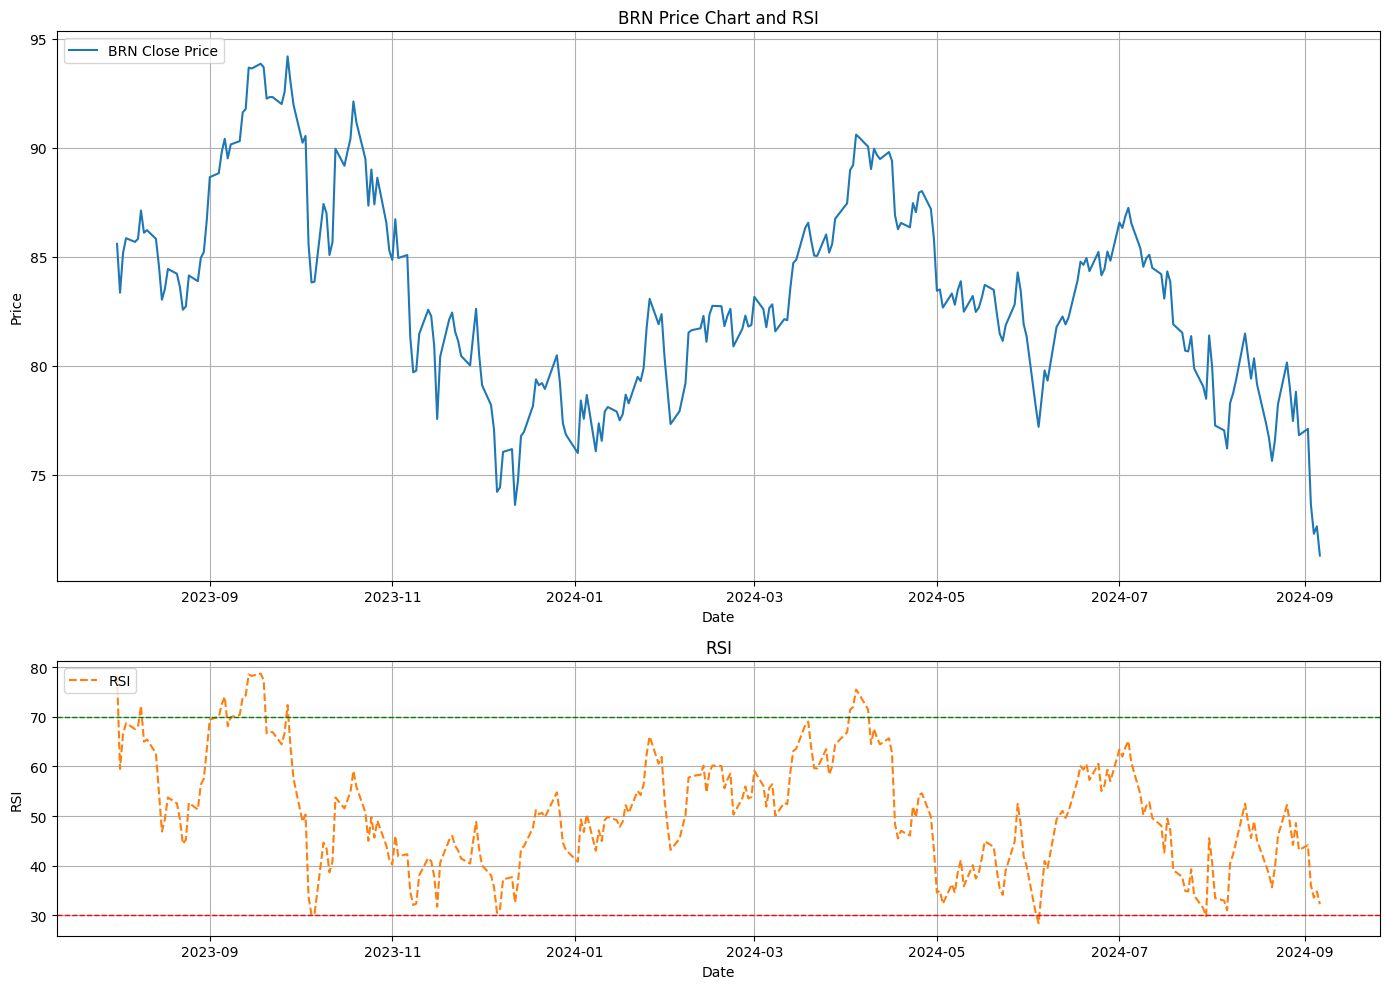

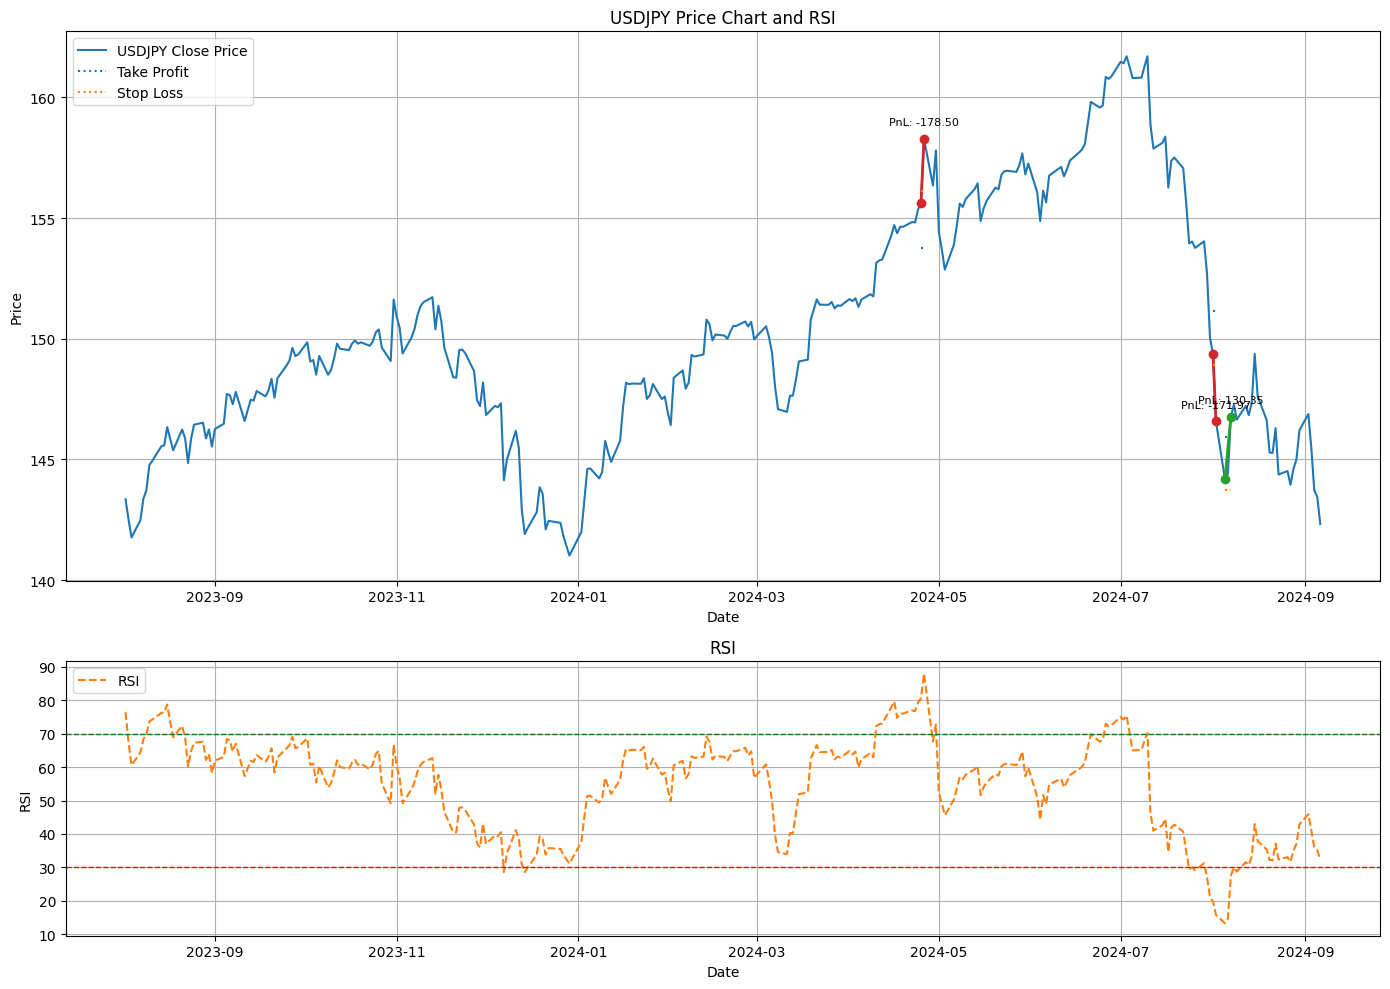

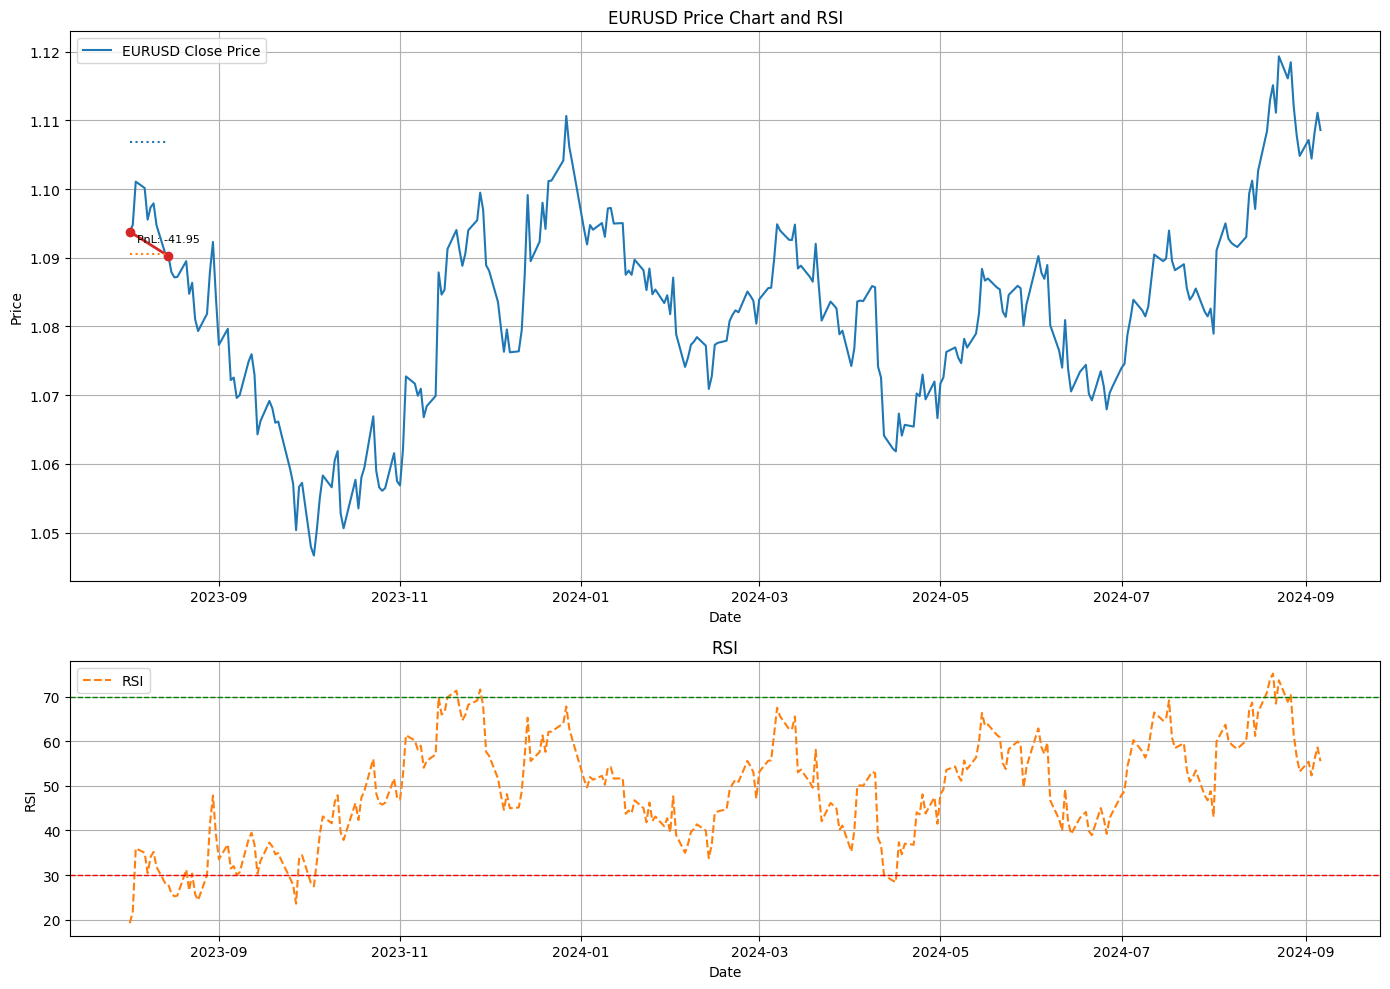

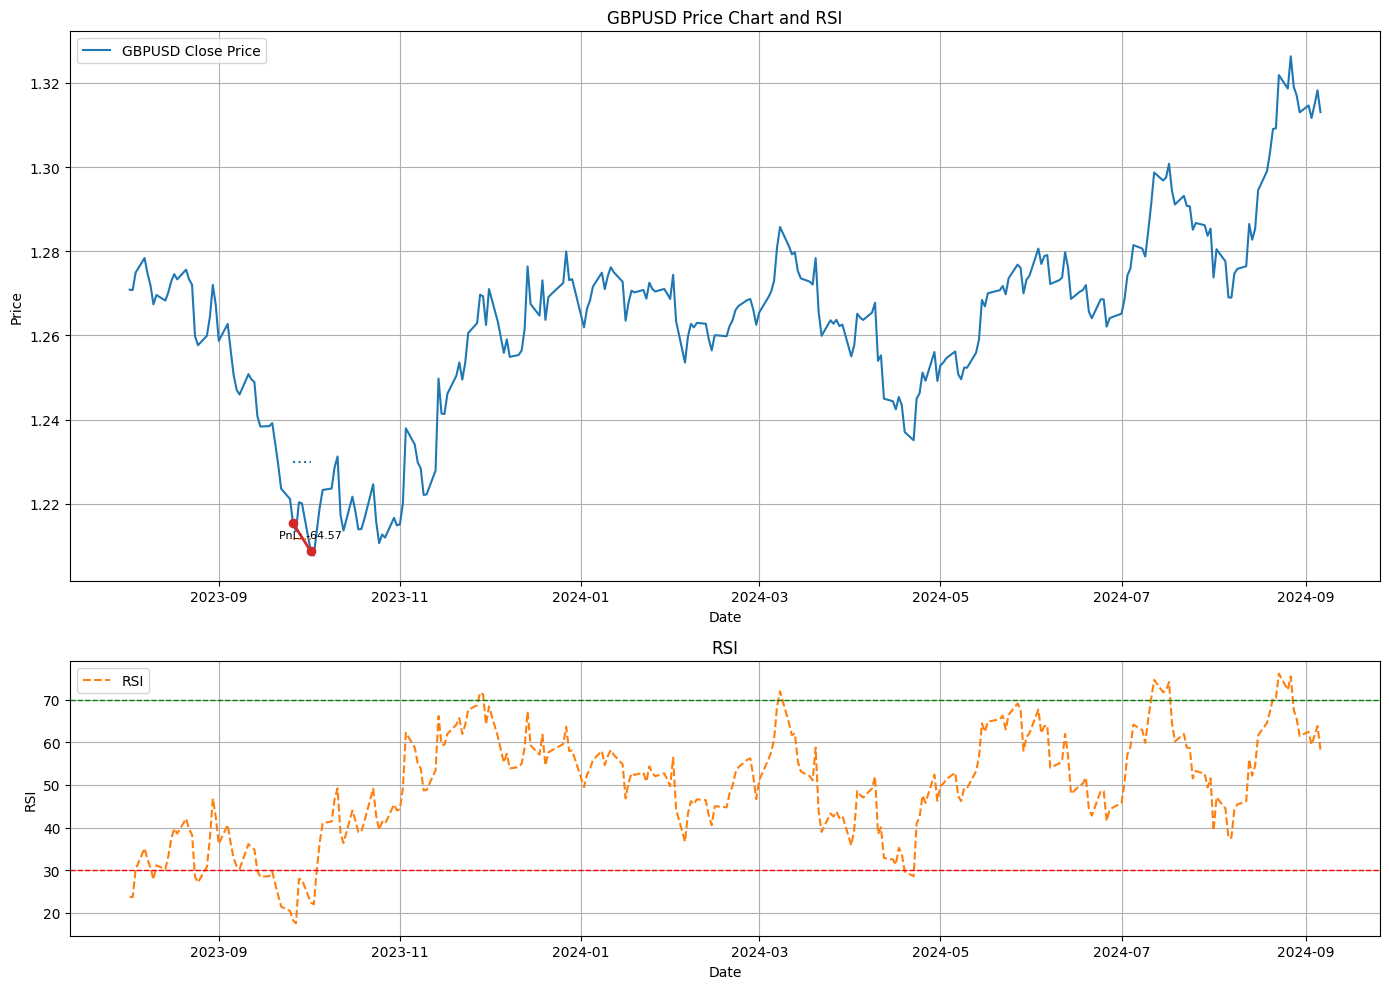

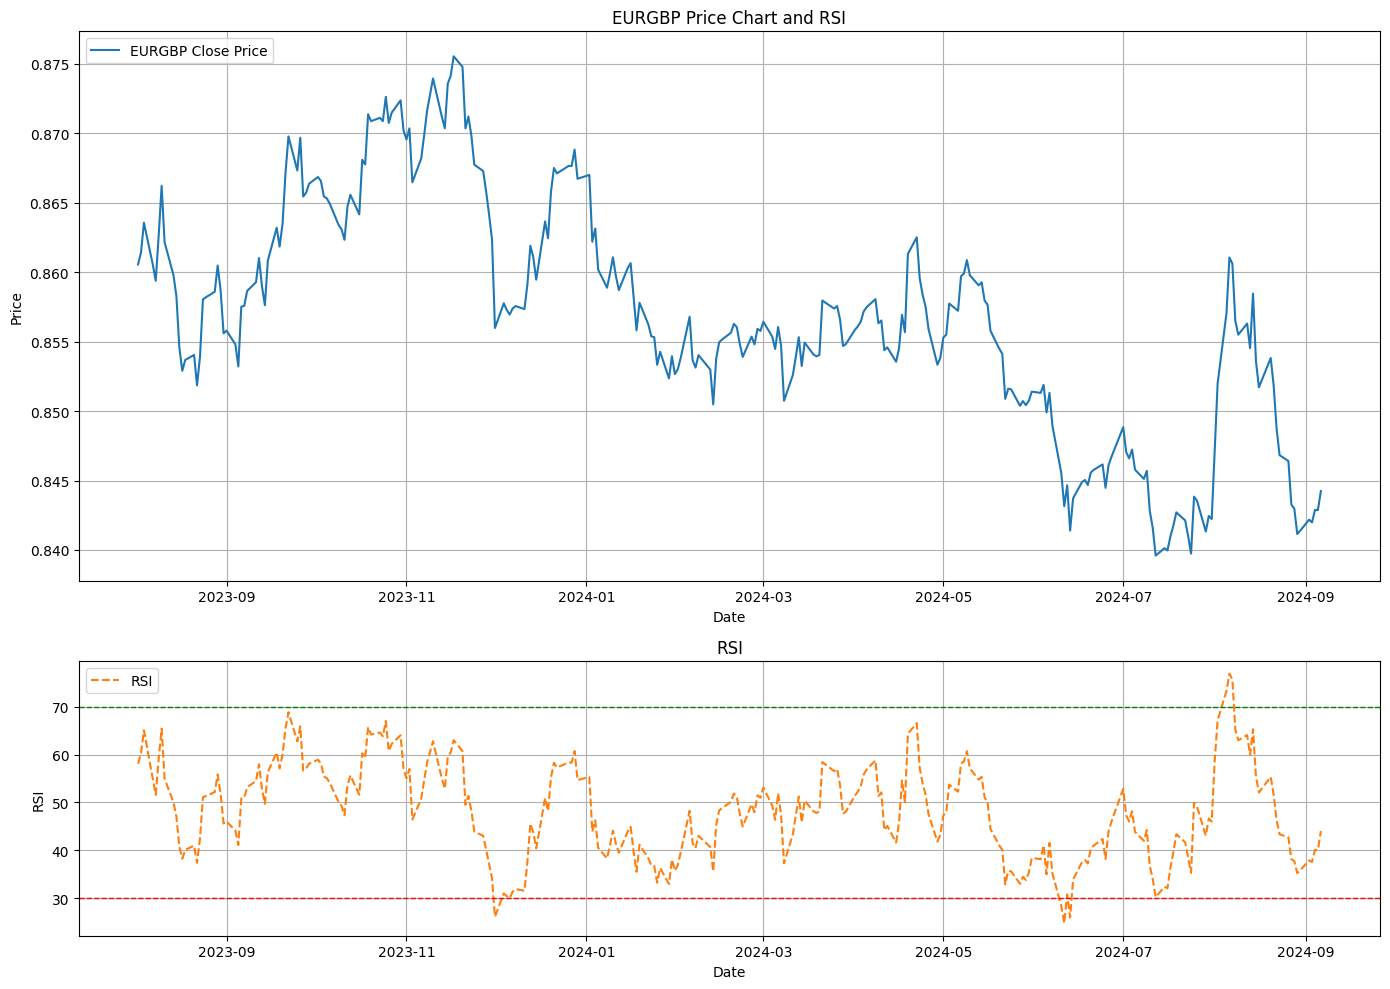

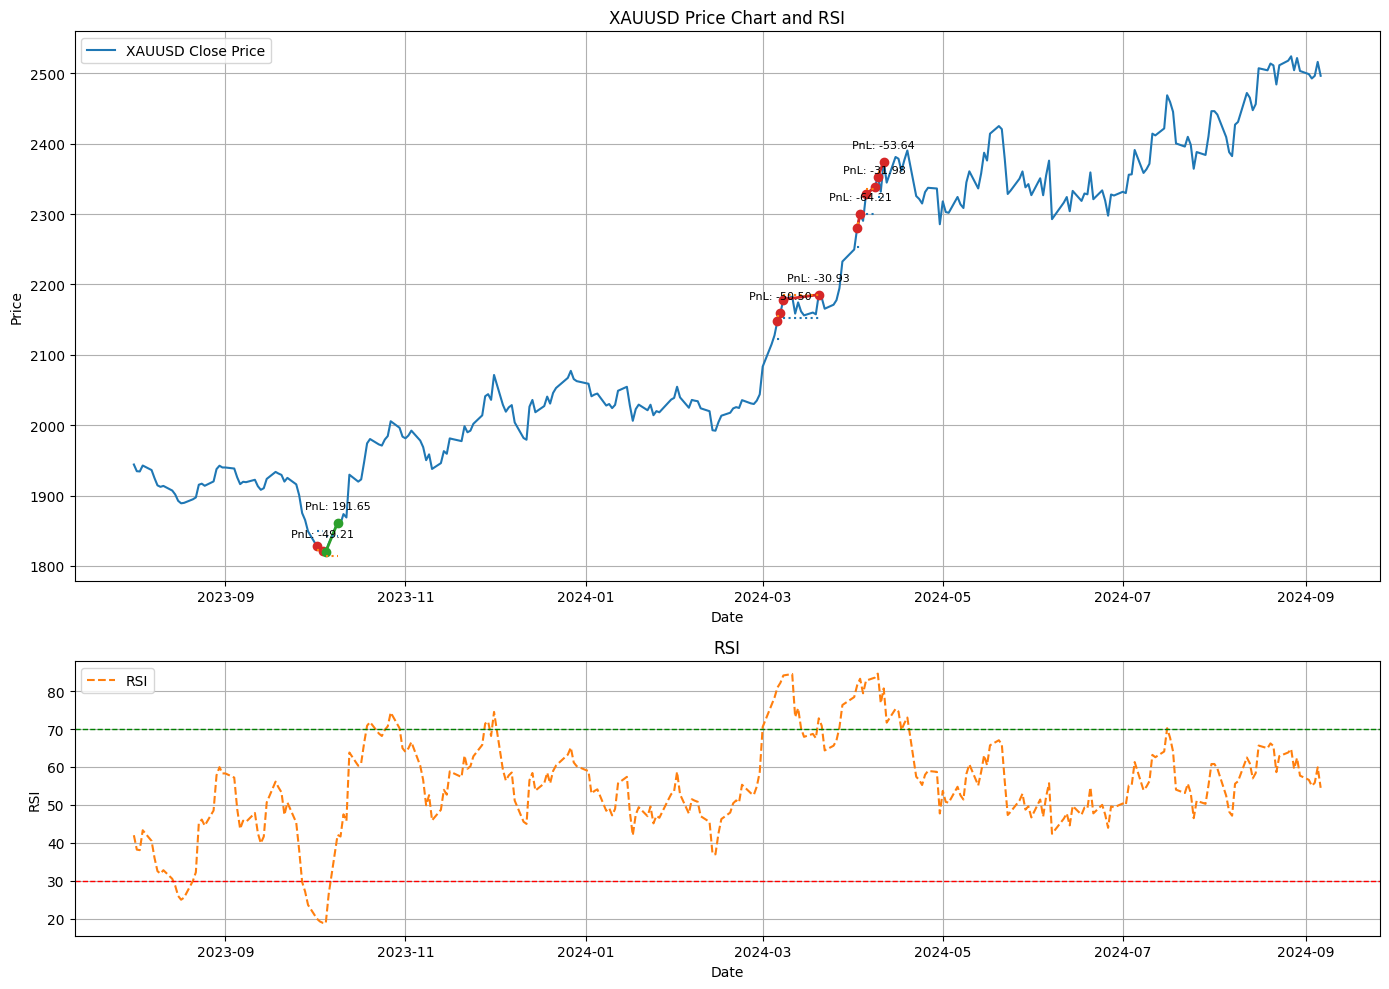

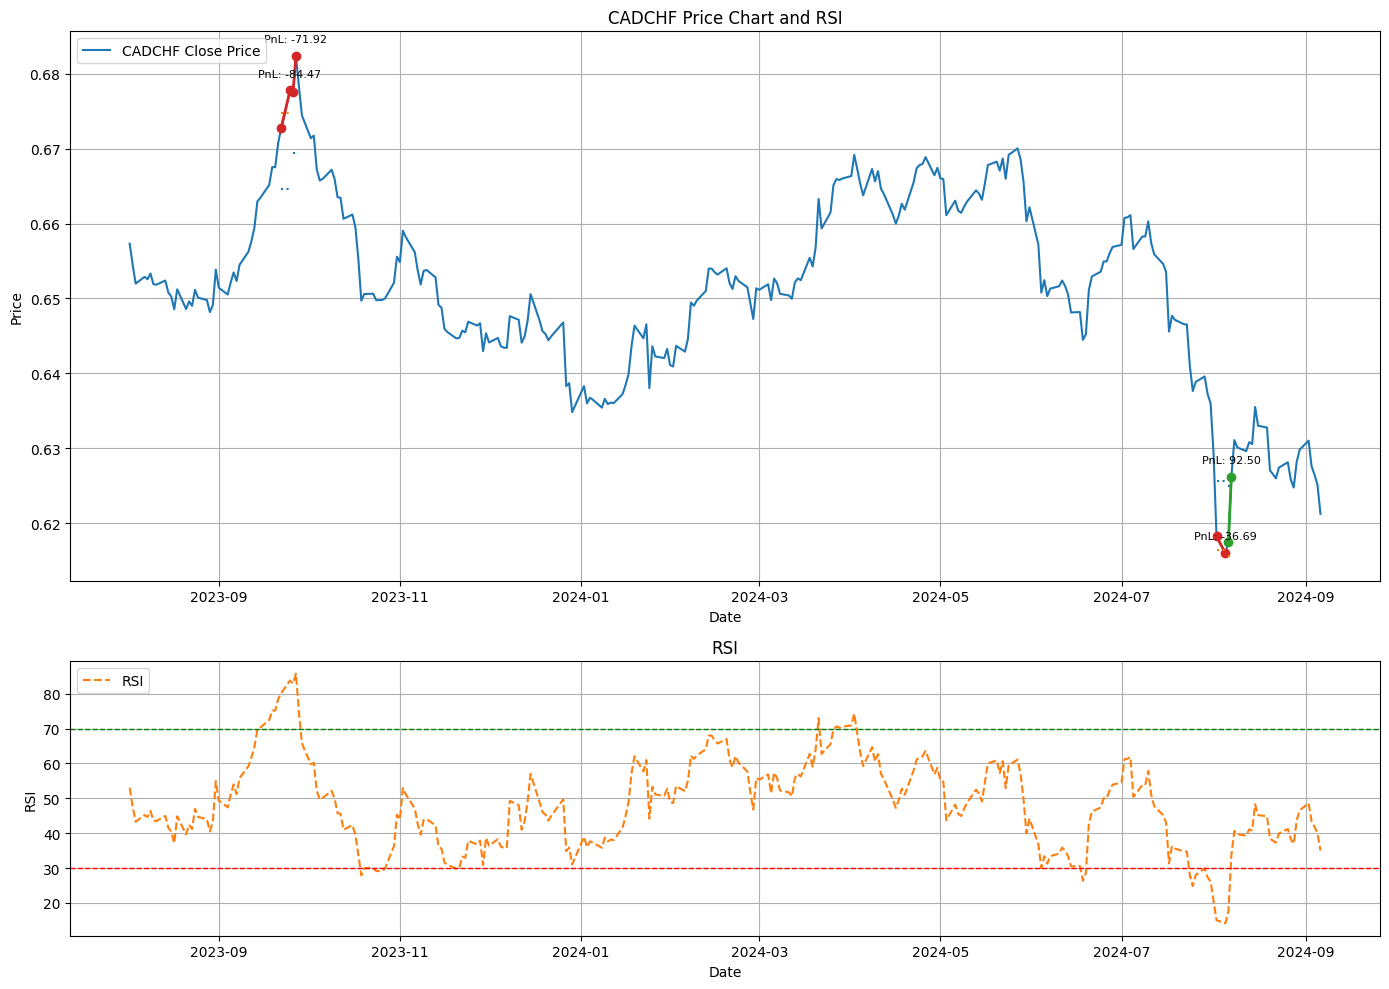

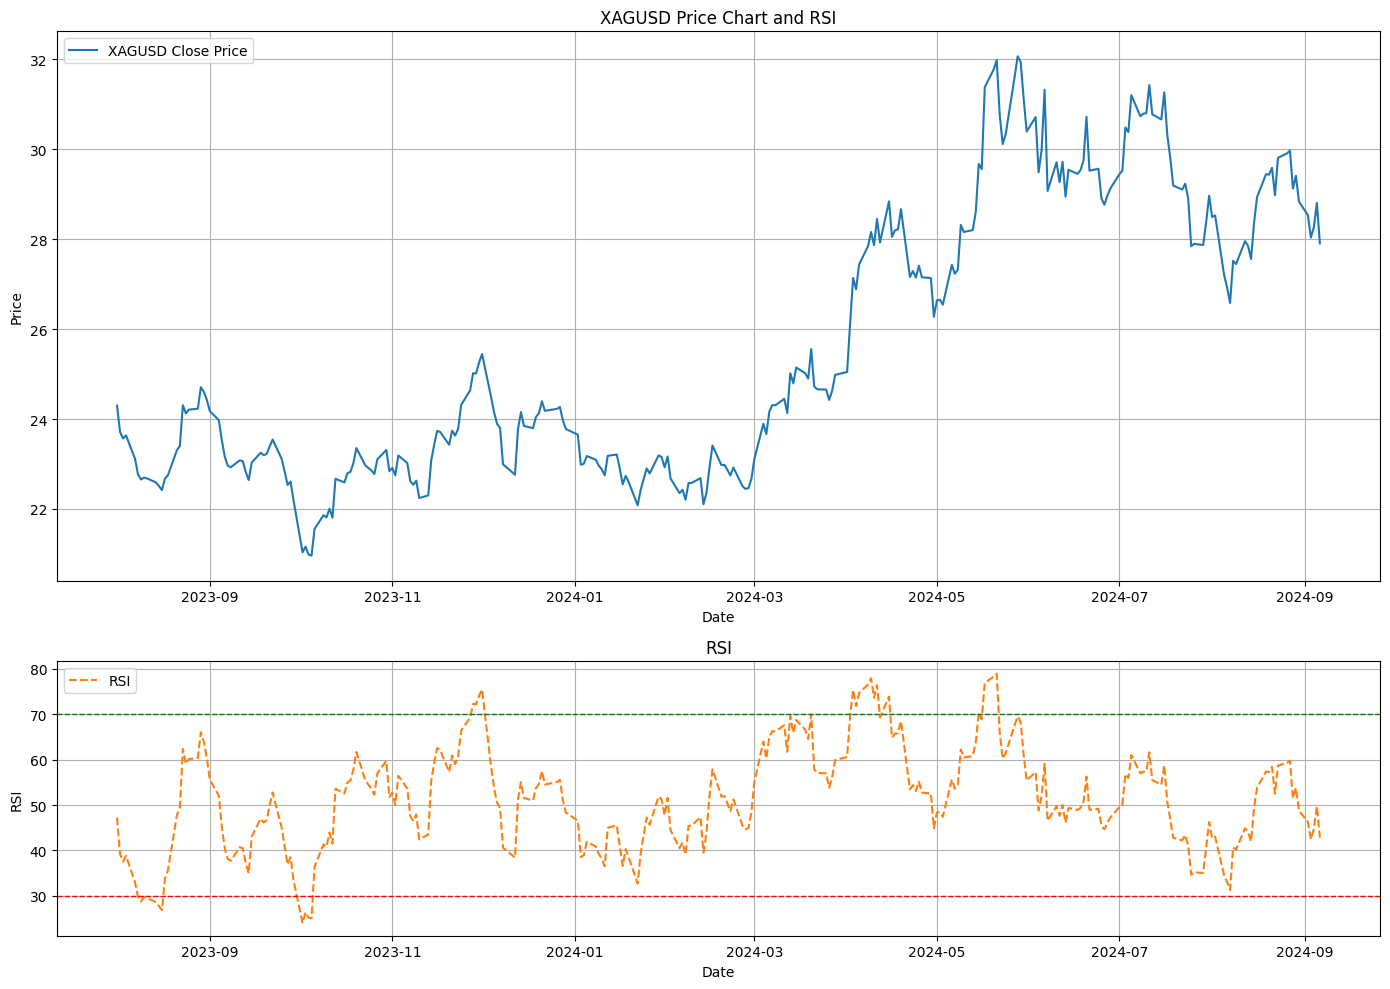

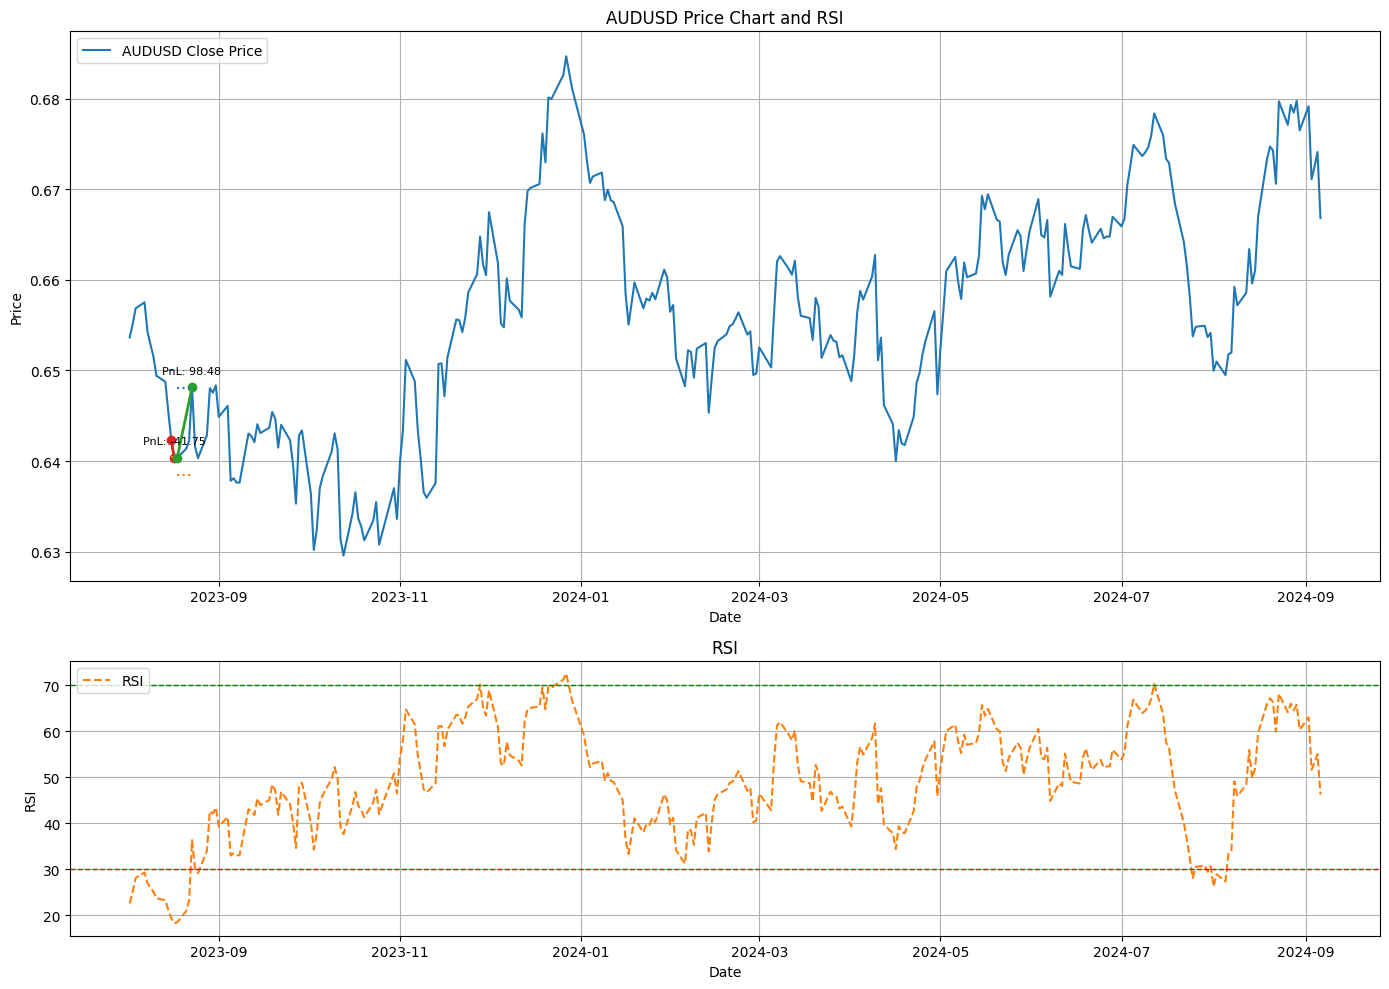

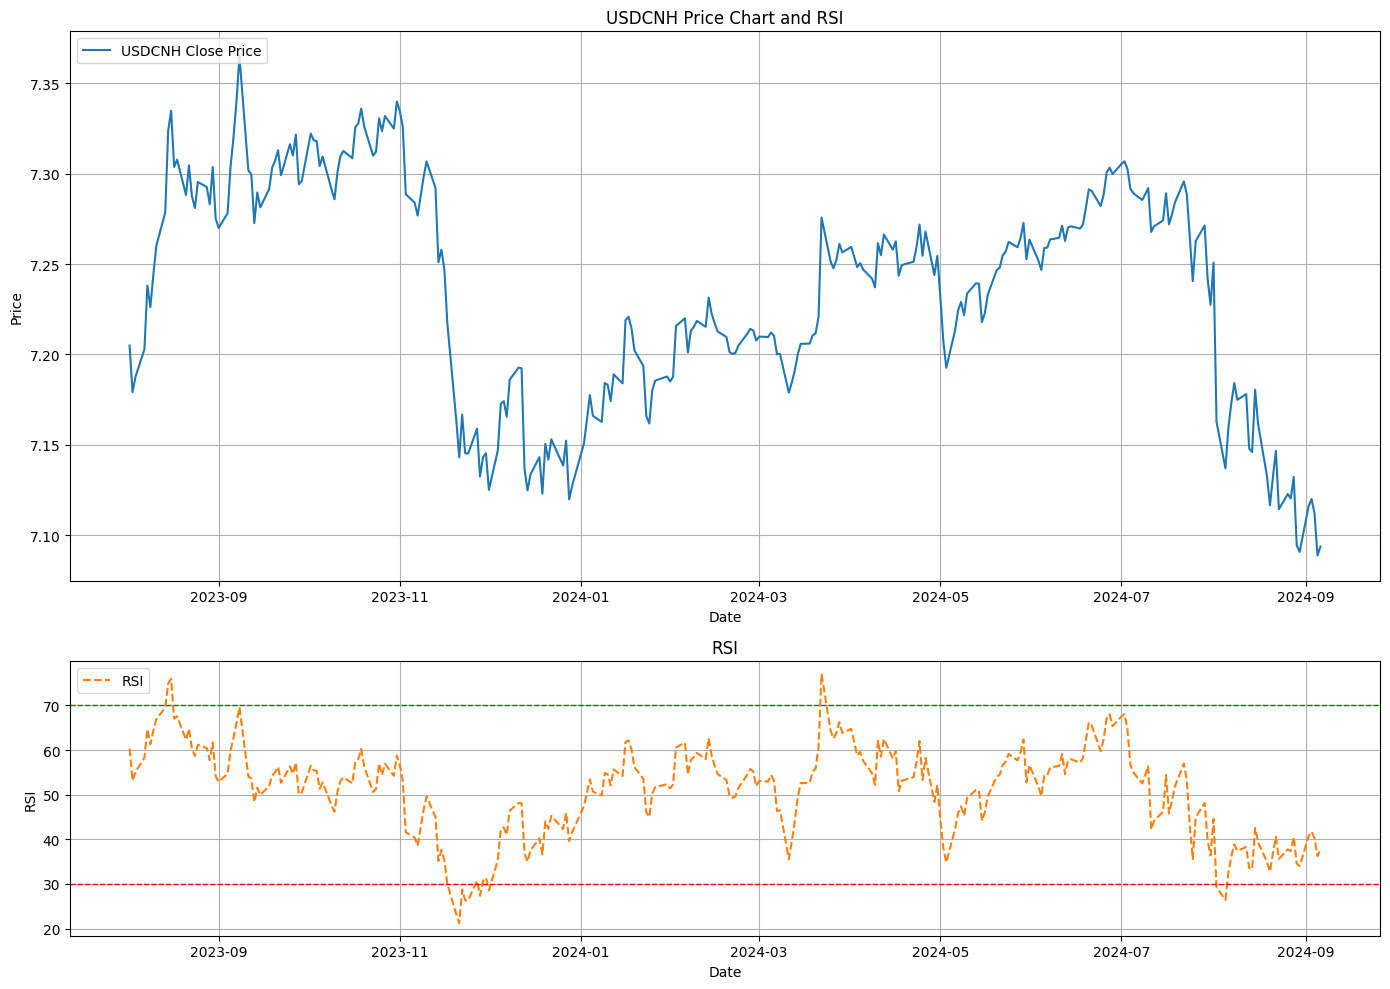

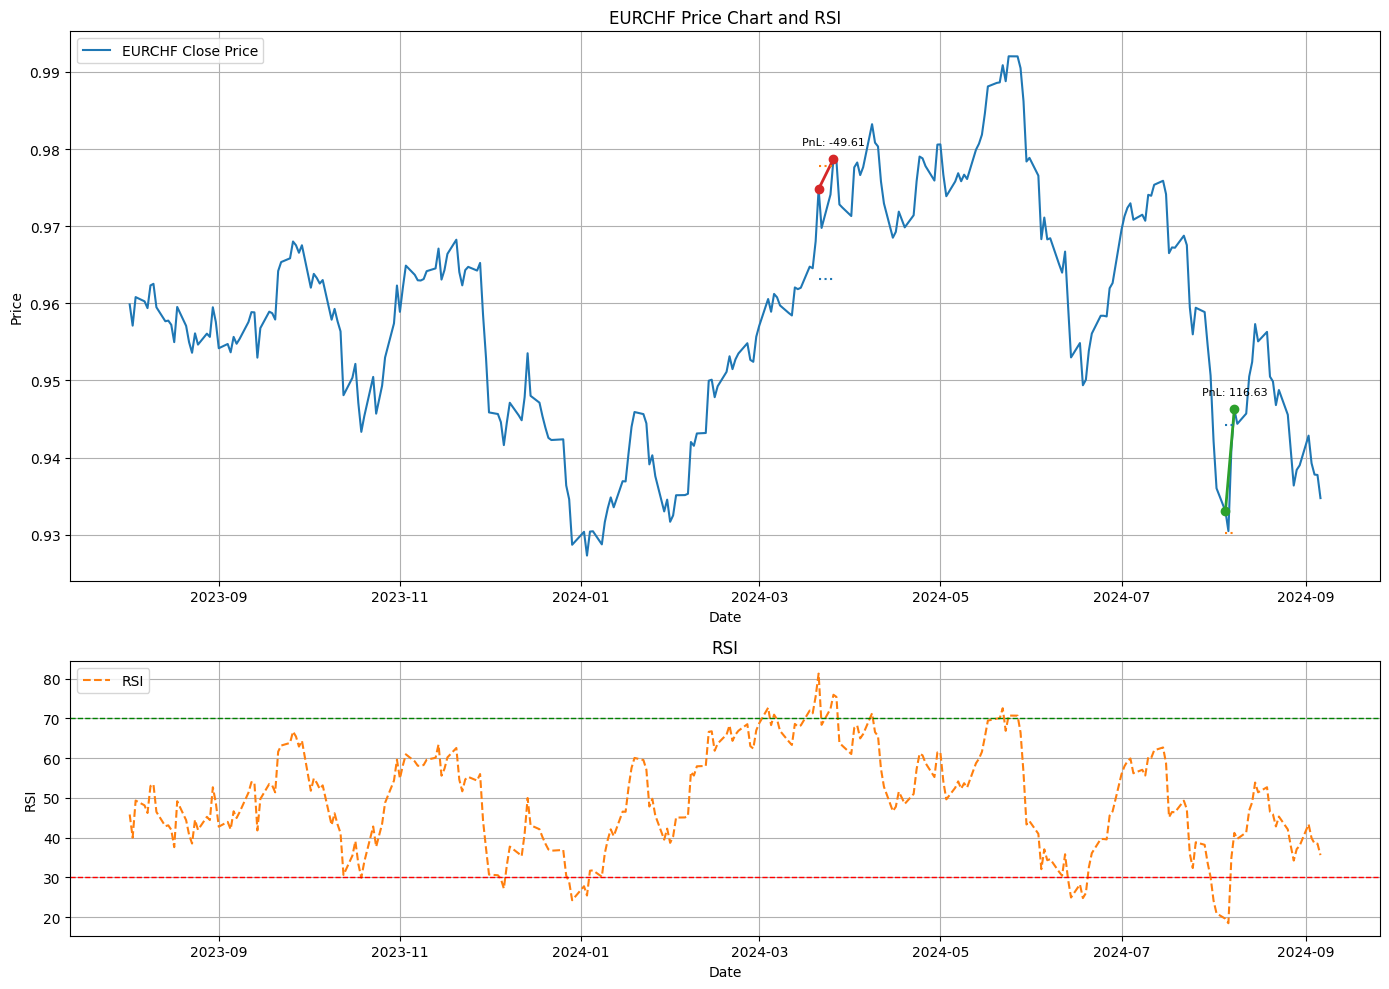

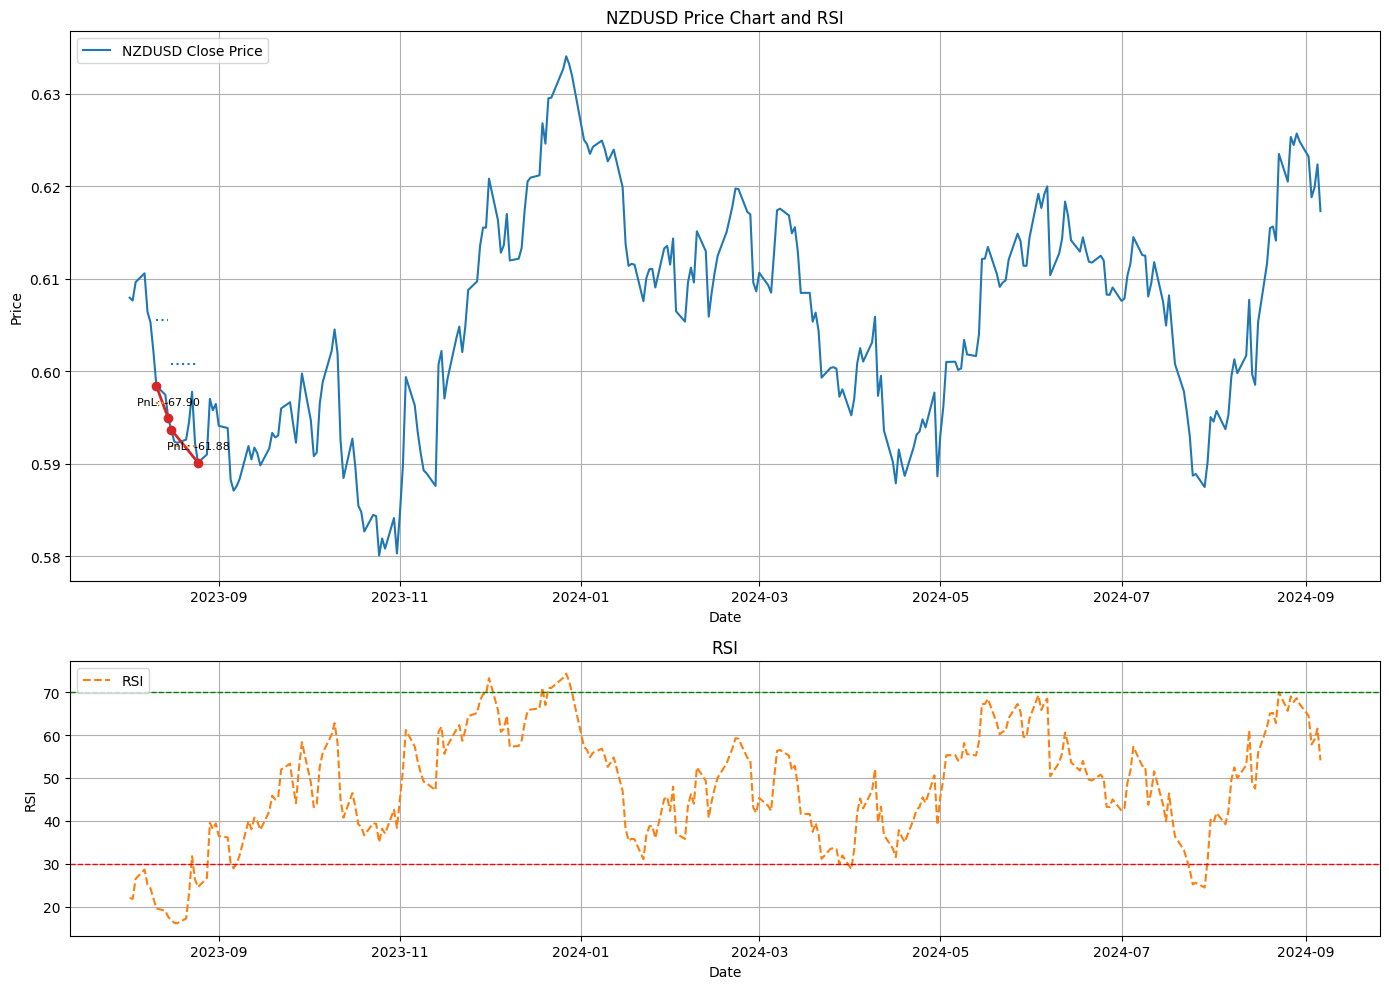

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

def plot_trades_for_all_symbols(trades_df, shared_data):
    # Define colors for different trade actions
    entry_color = '#2ca02c'  # Green for entry
    exit_color = '#d62728'   # Red for exit
    tp_color = '#1f77b4'     # Blue for Take Profit
    sl_color = '#ff7f0e'     # Orange for Stop Loss

    # Iterate through each symbol's data
    for symbol, price_data in shared_data.items():
        # Initialize the figure and GridSpec
        fig = plt.figure(figsize=(14, 10))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

        # Create subplots
        ax1 = plt.subplot(gs[0])  # Price chart
        ax2 = plt.subplot(gs[1])  # RSI chart

        # Ensure time columns are in datetime format
        price_data['time'] = pd.to_datetime(price_data['time'])
        ax1.plot(price_data['time'], price_data['close'], label=f'{symbol} Close Price', color='#1f77b4', linewidth=1.5)

        if 'rsi' in price_data.columns:
            ax2.plot(price_data['time'], price_data['rsi'], label='RSI', color='#ff7f0e', linestyle='--', linewidth=1.5)

        # Filter trades for the current symbol
        symbol_trades = trades_df[trades_df['symbol'] == symbol].copy()
        symbol_trades['entry_time'] = pd.to_datetime(symbol_trades['entry_time'])
        symbol_trades['exit_time'] = pd.to_datetime(symbol_trades['exit_time'])

        # Plot each trade on the price chart
        for i, trade in symbol_trades.iterrows():
            entry_time = trade['entry_time']
            exit_time = trade['exit_time']
            entry_price = trade['entry_price']
            tp = trade['tp']
            sl = trade['sl']
            close_price = trade['close_price']
            pnl = trade['pnl']

            # Plot the trade entry and exit
            ax1.plot([entry_time, exit_time], [entry_price, close_price], marker='o', color=entry_color if pnl > 0 else exit_color, linestyle='-', linewidth=2)

            # Plot TP and SL as horizontal lines
            ax1.hlines(tp, xmin=entry_time, xmax=exit_time, colors=tp_color, linestyles='dotted', label='Take Profit' if i == 0 else "", linewidth=1.5)
            ax1.hlines(sl, xmin=entry_time, xmax=exit_time, colors=sl_color, linestyles='dotted', label='Stop Loss' if i == 0 else "", linewidth=1.5)

            # Annotate the trade with PnL
            ax1.annotate(f'PnL: {pnl:.2f}', (exit_time, close_price), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, color='black')

        # Formatting the price chart
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{symbol} Price Chart and RSI')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # Formatting the RSI chart
        if 'rsi' in price_data.columns:
            ax2.set_xlabel('Date')
            ax2.set_ylabel('RSI')
            ax2.axhline(y=30, color='red', linestyle='--', linewidth=1)
            ax2.axhline(y=70, color='green', linestyle='--', linewidth=1)
            ax2.set_title('RSI')
            ax2.legend(loc='upper left')
            ax2.grid(True)

        # Adjust the layout for better appearance
        plt.tight_layout()
        plt.show()

# Example usage
plot_trades_for_all_symbols(trades_df, shared.data)
